# Manual temporal GNN using PyG

## Data generation code

In [1]:
import torch
from torch_geometric.data import Data, Dataset

class PouchTemporalDataset(Dataset):
    def __init__(self, Ca, edge_index):
        """
        Ca: numpy array, shape (N, T)
        edge_index: torch.LongTensor, shape (2, E)
        """
        super().__init__()
        self.Ca = torch.tensor(Ca, dtype=torch.float)      # (N, T)
        self.edge_index = edge_index
        self.T = Ca.shape[1]

    def len(self):
        # One data point per (t -> t+1)
        return self.T - 1

    def get(self, idx):
        # x = Ca at time t
        x = self.Ca[:, idx].unsqueeze(1)      # (N, 1)
        # y = Ca at time t+1
        y = self.Ca[:, idx+1].unsqueeze(1)    # (N, 1)

        return Data(
            x=x,
            y=y,
            edge_index=self.edge_index
        )


## GraphSAGE -> GRU -> Linear Model

In [2]:
import torch
import torch.nn as nn
from torch_geometric.nn import SAGEConv

class SAGE_GRU_Autoregressive(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=32):
        super().__init__()

        # Spatial aggregator (GraphSAGE)
        self.sage = SAGEConv(in_channels, hidden_channels)

        # Temporal recurrence per node
        self.gru = nn.GRU(hidden_channels, hidden_channels, batch_first=True)

        # Decoder back to Ca(t+1)
        self.lin = nn.Linear(hidden_channels, 1)

        self.hidden_channels = hidden_channels

    def forward(self, x_t, edge_index, h):
        """
        x_t: (N, 1) – Ca at time t
        edge_index: graph edges
        h: (1, N, hidden_dim) – GRU hidden state
        """

        # 1) Spatial message passing
        g = self.sage(x_t, edge_index)       # (N, H)
        g = torch.relu(g)

        # 2) GRU expects (batch, sequence, features)
        g_seq = g.unsqueeze(0)               # (1, N, H)
        out, h_new = self.gru(g_seq, h)      # out: (1, N, H)

        # 3) Predict next Calcium
        pred = self.lin(out.squeeze(0))      # (N, 1)

        return pred, h_new

    def init_hidden(self, N):
        return torch.zeros(1, N, self.hidden_channels)


In [3]:
class SAGE_GRU_Autoregressive2(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=32):
        super().__init__()

        self.sage = SAGEConv(in_channels, hidden_channels)

        # GRU per node (each node is a batch element)
        self.gru = nn.GRU(hidden_channels, hidden_channels, batch_first=False)

        self.lin = nn.Linear(hidden_channels, 1)
        self.hidden_channels = hidden_channels

    def forward(self, x_t, edge_index, h):
        # Spatial step
        g = self.sage(x_t, edge_index)   # (N, H)
        g = torch.relu(g)

        # Make seq_len=1, batch=N
        g_seq = g.unsqueeze(0)           # (1, N, H)

        # GRU
        out, h_new = self.gru(g_seq, h)  # h shape: (1, N, H)

        # Decode next state
        pred = self.lin(out.squeeze(0))  # (N,1)

        return pred, h_new

    def init_hidden(self, N):
        return torch.zeros(1, N, self.hidden_channels)


## Training Loop

In [4]:
from torch_geometric.loader import DataLoader

def train_model(model, dataset, epochs=50, lr=1e-3):
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    N = dataset.Ca.shape[0]   # number of cells
    print(f"Training on {N} nodes.")

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        # Reset GRU hidden state each epoch
        h = model.init_hidden(N)

        for data in loader:
            x = data.x          # (N,1)
            y = data.y          # (N,1)
            edge_index = data.edge_index

            pred, h = model(x, edge_index, h)

            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch}: Loss = {total_loss:.6f}")


In [5]:
def train_model2(model, dataset, epochs=50, lr=1e-3):
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    N = dataset.Ca.shape[0]

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        h = model.init_hidden(N)

        for data in loader:
            x = data.x
            y = data.y
            edge_index = data.edge_index

            # Forward
            pred, h = model(x, edge_index, h)

            # ⛔ CRITICAL: Detach hidden state so graph doesn't grow across timesteps
            h = h.detach()

            # Compute loss
            loss = loss_fn(pred, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch}: Loss = {total_loss:.6f}")

## Autoregressive Rollout for Testing

In [6]:
def autoregressive_rollout(model, x0, edge_index, steps=200):
    """
    x0: (N,1) initial Ca frame
    """
    model.eval()

    N = x0.shape[0]
    h = model.init_hidden(N)

    x_t = x0
    preds = [x0.detach().cpu().numpy()]

    for _ in range(steps):
        x_next, h = model(x_t, edge_index, h)
        preds.append(x_next.detach().cpu().numpy())
        x_t = x_next

    # returns array (steps+1, N, 1)
    return np.stack(preds, axis=1)


# Pipeline

## Load a simulation output

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

ca_models_lib_mac = "/Users/scini/Documents/GitHub/Systems_Bio/ca_models_lib.py" 
ca_models_lib_path = ca_models_lib_mac  # Change this if on a different system

# Add the directory containing ca_models_lib.py to sys.path
import sys
import os
if ca_models_lib_path not in sys.path:
    sys.path.append(os.path.dirname(ca_models_lib_path))

import ca_models_lib as caml

import pandas as pd
import time


In [8]:
# Load data
folder_path_pc = r"C:\Users\steph\Box\ZartmanLabGroupFolder\Zartman_Dowling\Stephen\MC2021_Data"
folder_path_mac = r"/Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data"

folder_path = folder_path_mac
# Get geometry files

# Select size
size = 'xsmall'  # Options: 'xsmall', 'small', 'medium', 'large',
# Load statics for wing disc geometries    
disc_vertices = np.load(os.path.join(folder_path, "geometry", "disc_vertices.npy"), allow_pickle=True).item()  # Vertices
disc_laplacians = np.load(os.path.join(folder_path, "geometry", "disc_sizes_laplacian.npy"), allow_pickle=True).item()  # Laplacian Matrix
disc_adjs = np.load(os.path.join(folder_path, "geometry", "disc_sizes_adj.npy"), allow_pickle=True).item()  # Adjacency matrix

adj_matrix=disc_adjs[size] # Adjacency Matrix
laplacian_matrix=disc_laplacians[size] # Laplacian Matrix
new_vertices=disc_vertices[size] # Vertices

# Number of cells
num_cells = new_vertices.shape[0]

In [9]:
disc_model_dense = caml.PouchModelScipy_dense(laplacian_matrix, sim_time=3600, dt=1, 
                                              t_eval_boolean=True, random_seed=123456  
                                              ) 

In [10]:
t_sim = time.perf_counter()
sig2 = disc_model_dense.simulate()
print(f"Step 2 took {time.perf_counter() - t_sim:.4f} seconds")

Step 2 took 32.8485 seconds


In [11]:
stim_cells2 = disc_model_dense.stimulated_cell_idxs

print(stim_cells2)

[175  66 173]


In [12]:
# print(Ca_conc.shape, IP3_conc.shape, R_conc.shape)
time_points2 = sig2.t
Ca_conc2 = sig2.y[:num_cells, :]
IP3_conc2 = sig2.y[num_cells:2*num_cells, :]
R_conc2 = sig2.y[2*num_cells:, :]

print(Ca_conc2.shape, IP3_conc2.shape, R_conc2.shape)

(195, 3600) (195, 3600) (195, 3600)


In [13]:
# Add 1% Gaussian noise
np.random.seed(123456)  # For reproducibility
Ca_conc2_noisy = Ca_conc2 + np.random.normal(0, 0.01 * np.std(Ca_conc2), Ca_conc2.shape)

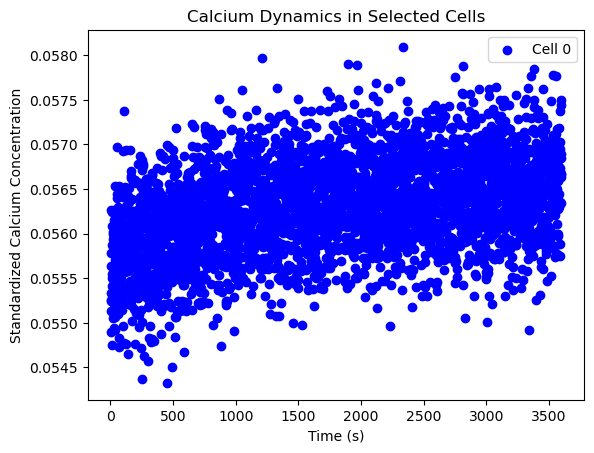

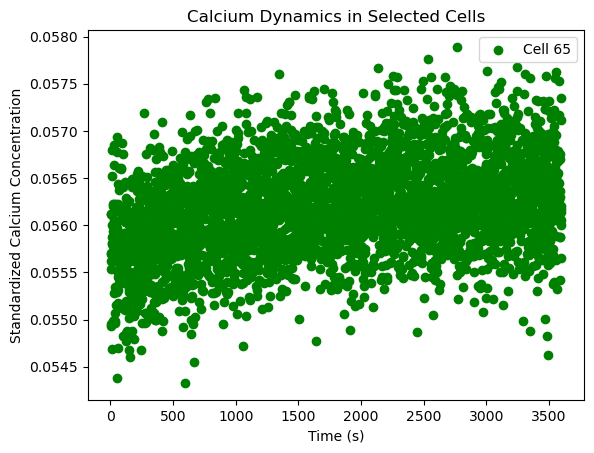

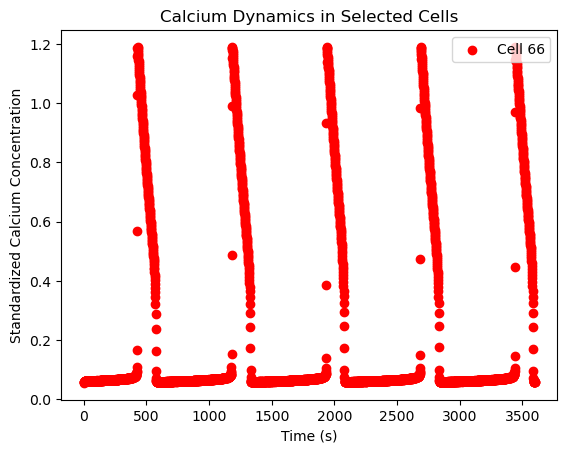

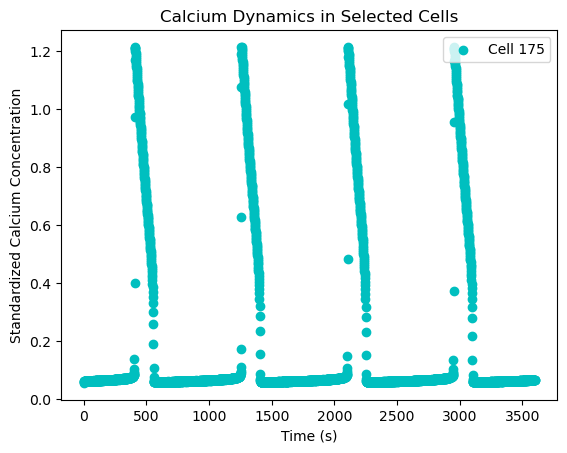

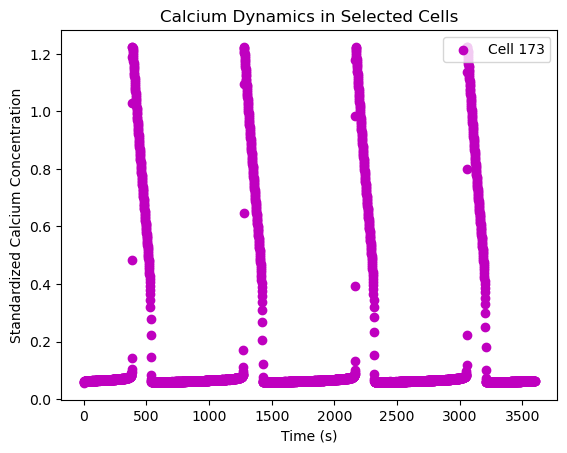

In [14]:
# Plot a few example cells to visualize the calcium dynamics

cell_indices = [0, 65, 66, 175 ,173 ]  # Example cell indices
colors = ['b', 'g', 'r', 'c', 'm']
for i in cell_indices:
    plt.scatter(time_points2[1:], Ca_conc2_noisy[i, 1:], label=f'Cell {i}', color=colors[cell_indices.index(i) % len(colors)])
    plt.xlabel('Time (s)')
    plt.ylabel('Standardized Calcium Concentration')
    plt.title('Calcium Dynamics in Selected Cells')
    plt.legend()
    plt.show()


In [28]:
off_diag_lap = laplacian_matrix - np.diag(np.diag(laplacian_matrix))
display(off_diag_lap)

is_symmetric = np.allclose(off_diag_lap, off_diag_lap.T)
print("Symmetric?", is_symmetric)

row, col = np.nonzero(off_diag_lap)
# np.array(row)
# np.array(col)

edge_index = torch.tensor([row, col], dtype=torch.long)
print(edge_index)
print(edge_index.shape)  # Should be [2, num_edges]
edge_weight = torch.tensor(off_diag_lap[row, col], dtype=torch.float32)


print(edge_weight)
print(edge_weight.shape)  # Should be [num_edges,]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 10.19337977],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., 10.19337977,
         0.        ,  0.        ]], shape=(195, 195))

Symmetric? True
tensor([[  0,   0,   1,  ..., 194, 194, 194],
        [  3,   5,   3,  ..., 188, 189, 192]])
torch.Size([2, 1064])
tensor([ 8.6643,  9.5087,  8.8120,  ...,  8.8206,  7.3286, 10.1934])
torch.Size([1064])


/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_46520/737813101.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1724788636709/work/torch/csrc/utils/tensor_new.cpp:281.)
  edge_index = torch.tensor([row, col], dtype=torch.long)


In [29]:
# Build PouchTemporalDataset
dataset = PouchTemporalDataset(Ca_conc2_noisy, edge_index)

In [17]:
# Make the model and train it
model = SAGE_GRU_Autoregressive2(in_channels=1, hidden_channels=32)
train_model2(model, dataset, epochs=50, lr=1e-3)

Epoch 0: Loss = 1.699586
Epoch 1: Loss = 0.069357


KeyboardInterrupt: 

In [18]:
# Autoregressive rollout
x0 = torch.tensor(Ca_conc2_noisy[:, 0]).unsqueeze(1).float()  # (N,1)
preds = autoregressive_rollout(model, x0, edge_index, steps=Ca_conc2_noisy.shape[1]-1)

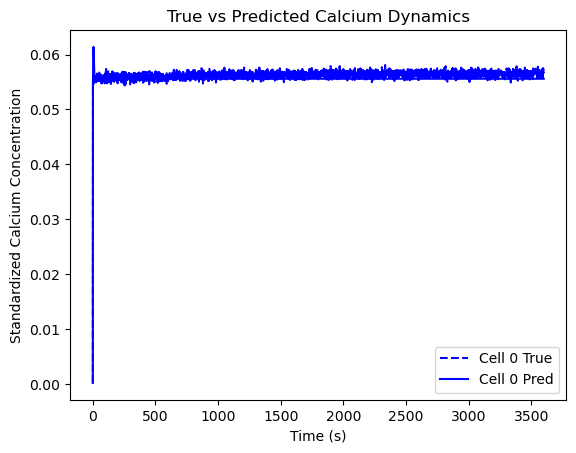

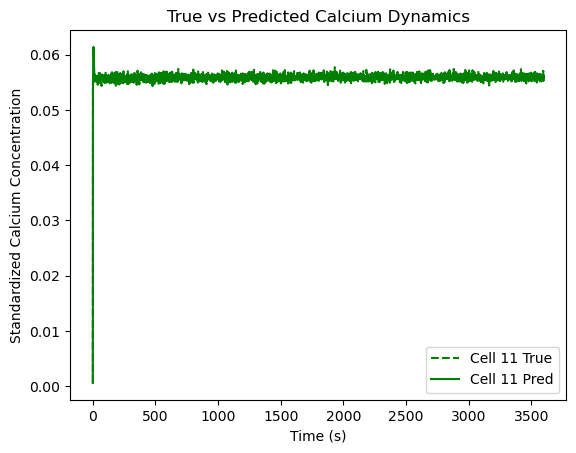

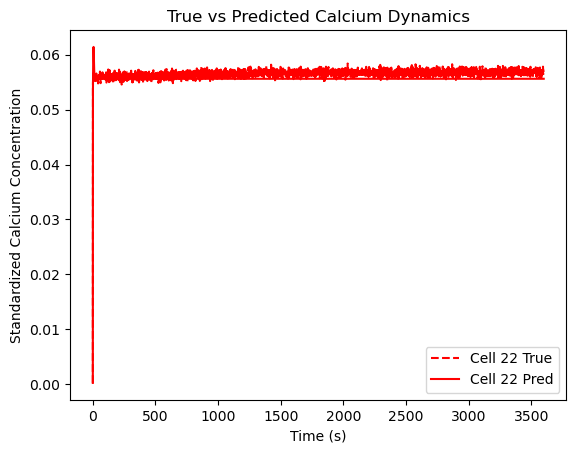

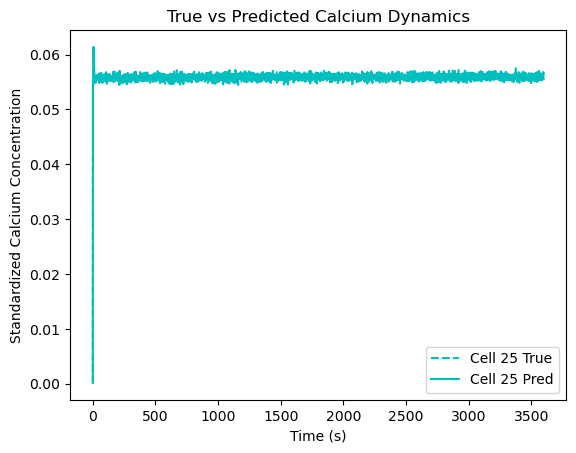

In [19]:
# Plot results for a few example cells
cell_indices = [0, 11, 22, 25 ]  #Example cell indices
colors = ['b', 'g', 'r', 'c', 'm']
for i in cell_indices:
    plt.plot(time_points2, Ca_conc2_noisy[i, :], label=f'Cell {i} True', color=colors[cell_indices.index(i) % len(colors)], linestyle='--')
    plt.plot(time_points2, preds[i, :, 0], label=f'Cell {i} Pred', color=colors[cell_indices.index(i) % len(colors)], linestyle='-')
    plt.xlabel('Time (s)')
    plt.ylabel('Standardized Calcium Concentration')
    plt.title('True vs Predicted Calcium Dynamics')
    plt.legend()
    plt.show()

## Normal training, no autoregression

In [30]:
def train_model_nextstep(model, dataset, epochs=50, lr=1e-3):
    loader = DataLoader(dataset, batch_size=1, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    N = dataset.Ca.shape[0]   # number of nodes/cells

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for data in loader:

            x = data.x          # (N,1)
            y = data.y          # (N,1)
            edge_index = data.edge_index

            # Reset hidden state EVERY time
            h = model.init_hidden(N)

            pred, h = model(x, edge_index, h)

            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch}: loss = {total_loss:.6f}")


In [31]:
def evaluate_nextstep(model, dataset):
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    model.eval()

    N = dataset.Ca.shape[0]
    preds, truths = [], []

    with torch.no_grad():
        for data in loader:
            x = data.x
            y = data.y
            edge_index = data.edge_index

            h = model.init_hidden(N)    # reset!
            pred, h = model(x, edge_index, h)

            preds.append(pred.cpu())
            truths.append(y.cpu())

    return preds, truths

In [ ]:
T_train = 3000
Ca = Ca_conc2_noisy

train_set = PouchTemporalDataset(Ca[:, :T_train], edge_index)
test_set  = PouchTemporalDataset(Ca[:, T_train-1:], edge_index)

# Save train and test sets
# torch.save(train_set, 'pouch_train_set_nextstep_11202025.pt')
# torch.save(test_set, 'pouch_test_set_nextstep_11202025.pt')

In [33]:
# Train next-step model
model_nextstep = SAGE_GRU_Autoregressive2(in_channels=1, hidden_channels=32)
train_model_nextstep(model_nextstep, train_set, epochs=50, lr=1e-3)


Epoch 0: loss = 0.152273
Epoch 1: loss = 0.050956
Epoch 2: loss = 0.053011
Epoch 3: loss = 0.050216
Epoch 4: loss = 0.048431
Epoch 5: loss = 0.046371
Epoch 6: loss = 0.045458
Epoch 7: loss = 0.044171
Epoch 8: loss = 0.042427
Epoch 9: loss = 0.046297
Epoch 10: loss = 0.042701
Epoch 11: loss = 0.042727
Epoch 12: loss = 0.042532
Epoch 13: loss = 0.042721
Epoch 14: loss = 0.041824
Epoch 15: loss = 0.042194
Epoch 16: loss = 0.041122
Epoch 17: loss = 0.041469
Epoch 18: loss = 0.041322
Epoch 19: loss = 0.040399
Epoch 20: loss = 0.041460
Epoch 21: loss = 0.040229
Epoch 22: loss = 0.039202
Epoch 23: loss = 0.041373
Epoch 24: loss = 0.039428
Epoch 25: loss = 0.039016
Epoch 26: loss = 0.039289
Epoch 27: loss = 0.038429
Epoch 28: loss = 0.038477
Epoch 29: loss = 0.037343
Epoch 30: loss = 0.039178
Epoch 31: loss = 0.037430
Epoch 32: loss = 0.037490
Epoch 33: loss = 0.038334
Epoch 34: loss = 0.037045
Epoch 35: loss = 0.037468
Epoch 36: loss = 0.036399
Epoch 37: loss = 0.035525
Epoch 38: loss = 0.036

In [34]:
# Test the model preds, truths = evaluate_nextstep(model_nextstep, test_set)
preds_list, truths_list = evaluate_nextstep(model_nextstep, test_set)

In [35]:
# Convert lists of (N,1) tensors into arrays
truths_arr = torch.stack([t.squeeze(1) for t in truths_list], dim=1).numpy()  # (N, T_test)
preds_arr  = torch.stack([p.squeeze(1) for p in preds_list],  dim=1).numpy()  # (N, T_test)

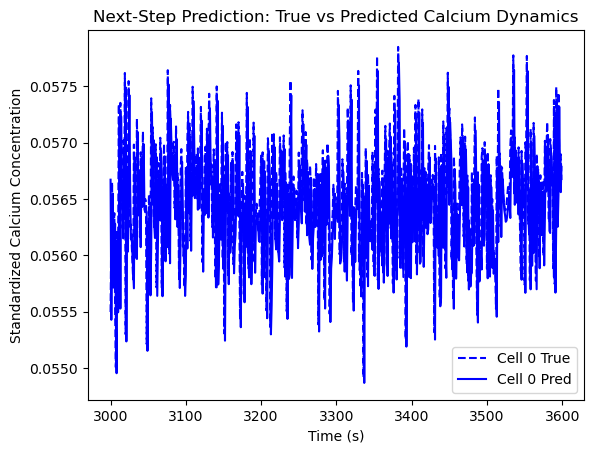

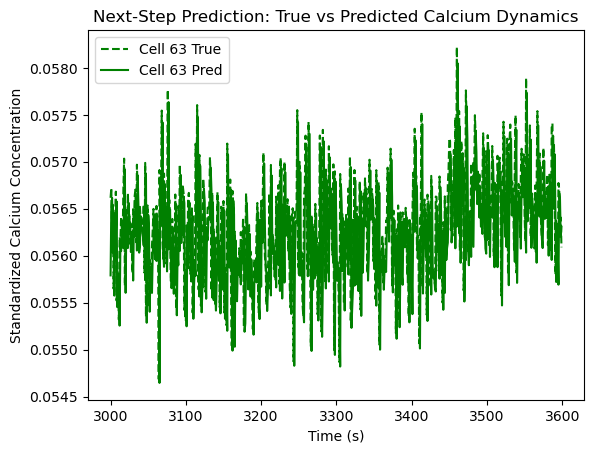

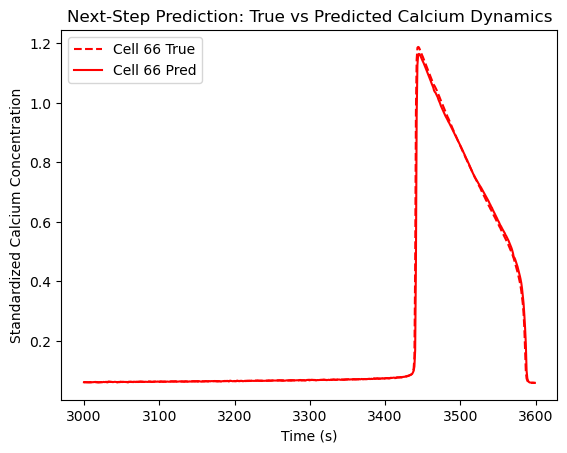

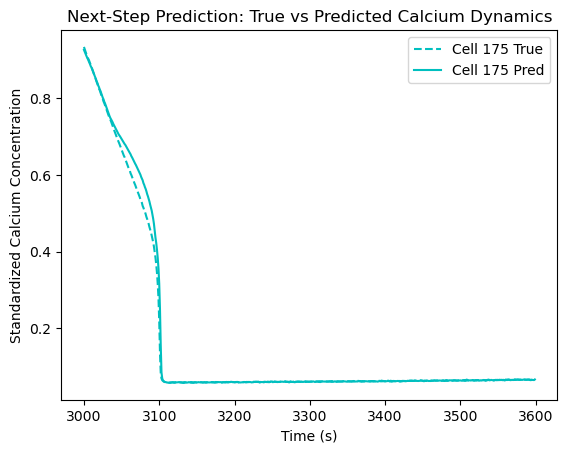

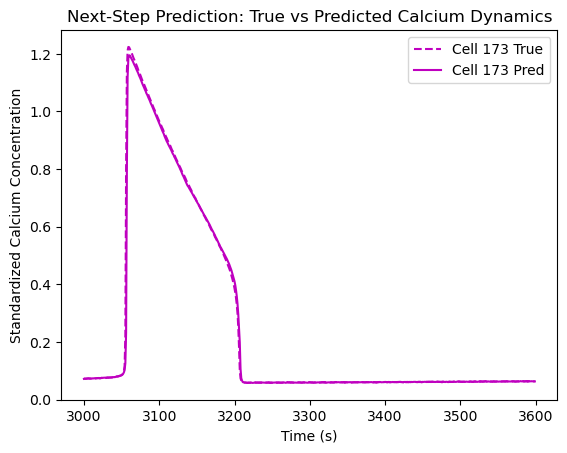

In [36]:
# Plot results for a few example cells
timepoints_test = time_points2[T_train:]

cell_indices = [0, 63, 66, 175, 173 ]  #Example cell indices
colors = ['b', 'g', 'r', 'c', 'm']
for i in cell_indices:
    plt.plot(timepoints_test, truths_arr[i, :], label=f'Cell {i} True', color=colors[cell_indices.index(i) % len(colors)], linestyle='--')
    plt.plot(timepoints_test, preds_arr[i, :], label=f'Cell {i} Pred', color=colors[cell_indices.index(i) % len(colors)], linestyle='-')
    plt.xlabel('Time (s)')
    plt.ylabel('Standardized Calcium Concentration')
    plt.title('Next-Step Prediction: True vs Predicted Calcium Dynamics')
    plt.legend()
    plt.show()

## Generate videos

In [121]:
import matplotlib
import seaborn as sns
from matplotlib import animation
from matplotlib import colors

def make_animation(ca, vertices, interval=50, normalize_flag=True): # Creation of calcium video
    colormap = plt.cm.Greens
    if normalize_flag:
        normalize = matplotlib.colors.Normalize(vmin=np.min(ca), vmax=max(np.max(ca),1))
    else:
        normalize = matplotlib.colors.Normalize(vmin=-np.max(np.abs(ca)), vmax=np.max(np.abs(ca)))
    with sns.axes_style("white"):
            fig=plt.figure(figsize=(25,15))
            fig.patch.set_alpha(0.)
            ax = fig.add_subplot(1,1,1)
            ax.axis('off')
            sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
            sm._A = []
            cbar=fig.colorbar(sm, ax=ax)
            cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=15,fontweight="bold")
            for cell in vertices:
                ax.plot(cell[:,0],cell[:,1], linewidth=0.0, color='w', alpha = 0.0)
            patches = [matplotlib.patches.Polygon(verts) for verts in vertices ]
                    # Timestamp generator, 1 sec increments
            def time_stamp_gen(n):
                for j in range(n):
                    if j%10==0:
                        yield f"Elapsed time: {j//60:02d}:{j%60:02d}"
            time_stamps=time_stamp_gen(len(ca[0,:]))
            def init():
                return [ax.add_patch(p) for p in patches]

            def animate(frame,time_stamps):
                for j in range(len(patches)):
                    c=colors.to_hex(colormap(normalize(frame[j])), keep_alpha=False)
                    patches[j].set_facecolor(c)
                ax.set_title( next(time_stamps) ,fontsize=50, fontweight="bold")
                return patches

            anim = animation.FuncAnimation(fig, animate, 
                                            init_func=init, 
                                            frames=ca[:,::10].T, # Calcium dynamics: [n cells x time-samples]
                                            fargs=(time_stamps,),
                                            interval=interval,
                                            blit=True)
            
            return anim

/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_46520/1629356130.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=15,fontweight="bold")


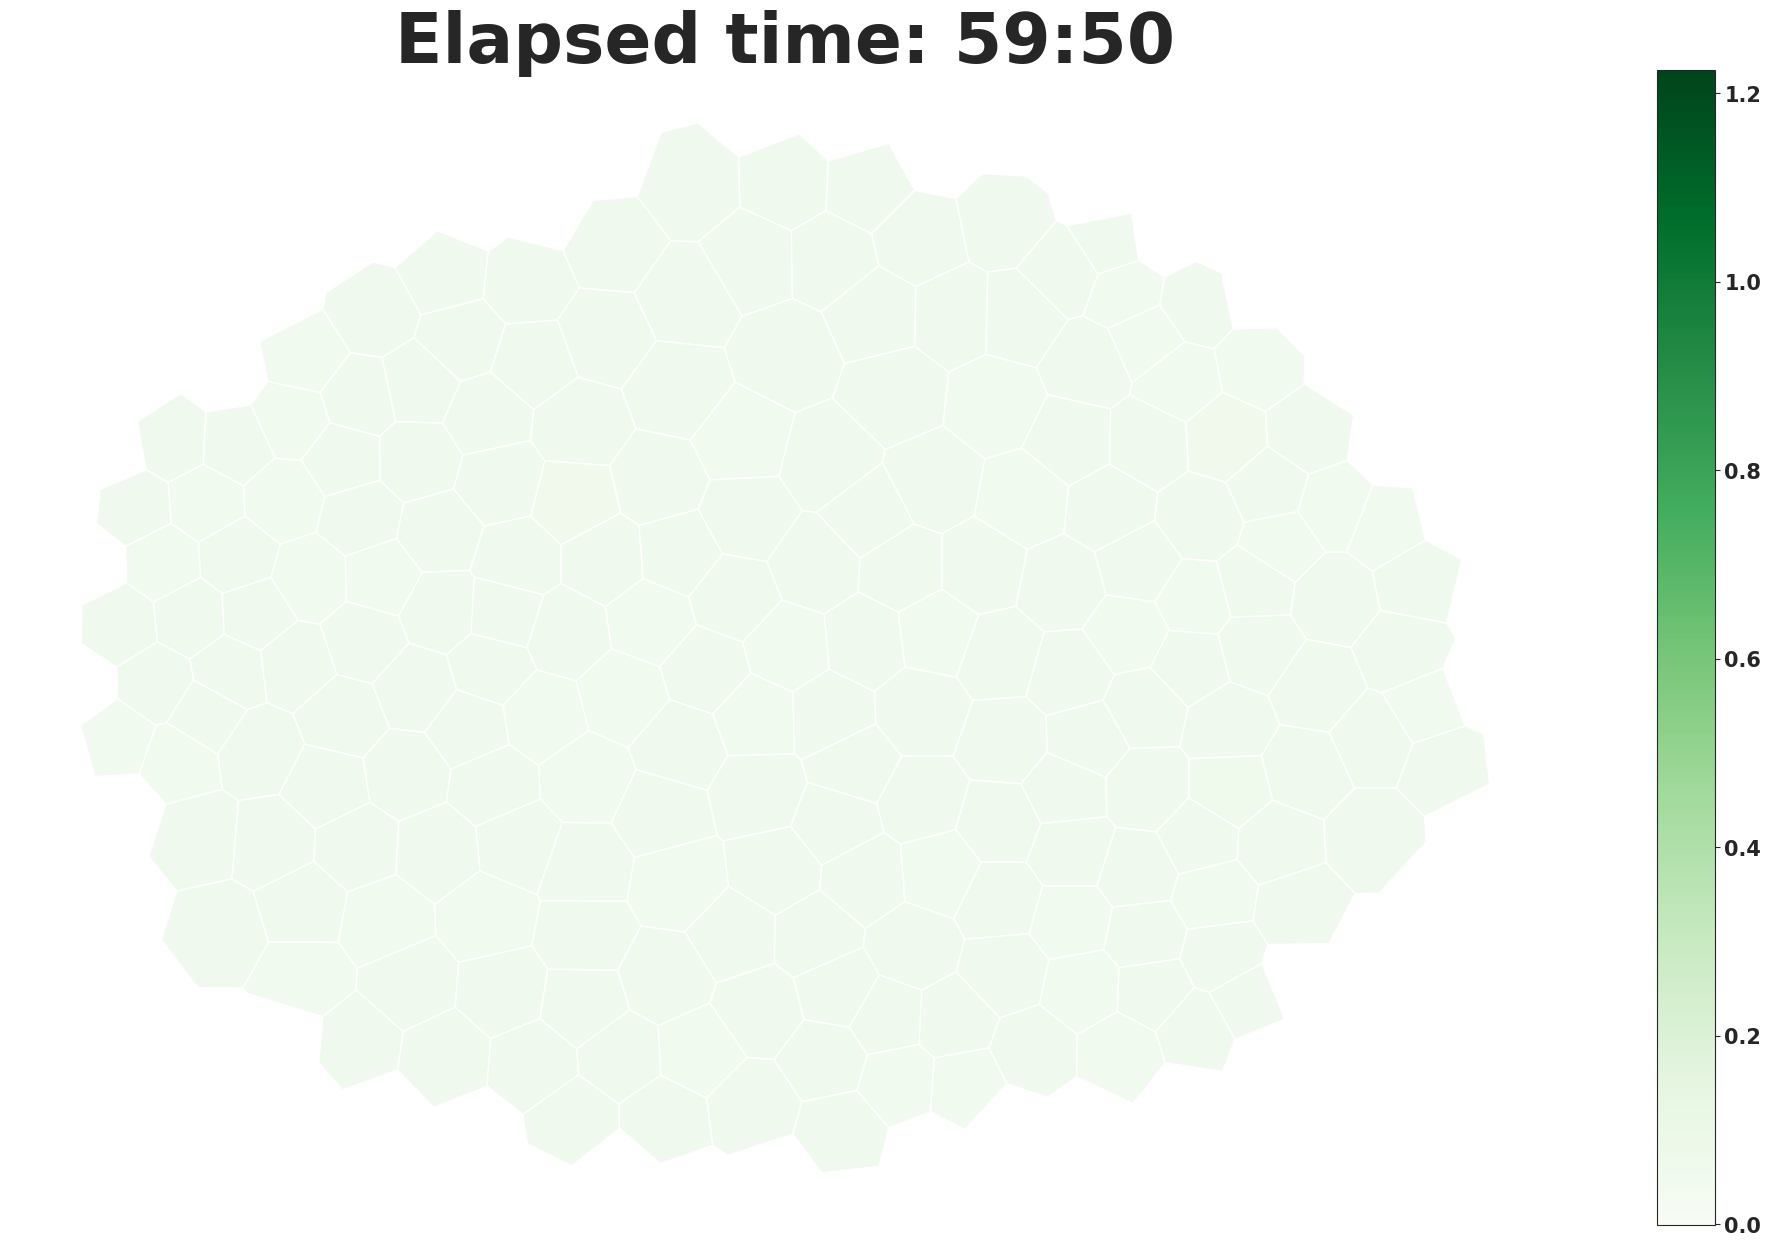

In [24]:
true_anim = make_animation(Ca_conc2_noisy, new_vertices)

# Save animation
true_anim.save('true_calcium_dynamics.mp4', writer='ffmpeg', dpi=200)

/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_46520/2185976013.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=15,fontweight="bold")
/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_46520/2185976013.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=15,fontweight="bold")


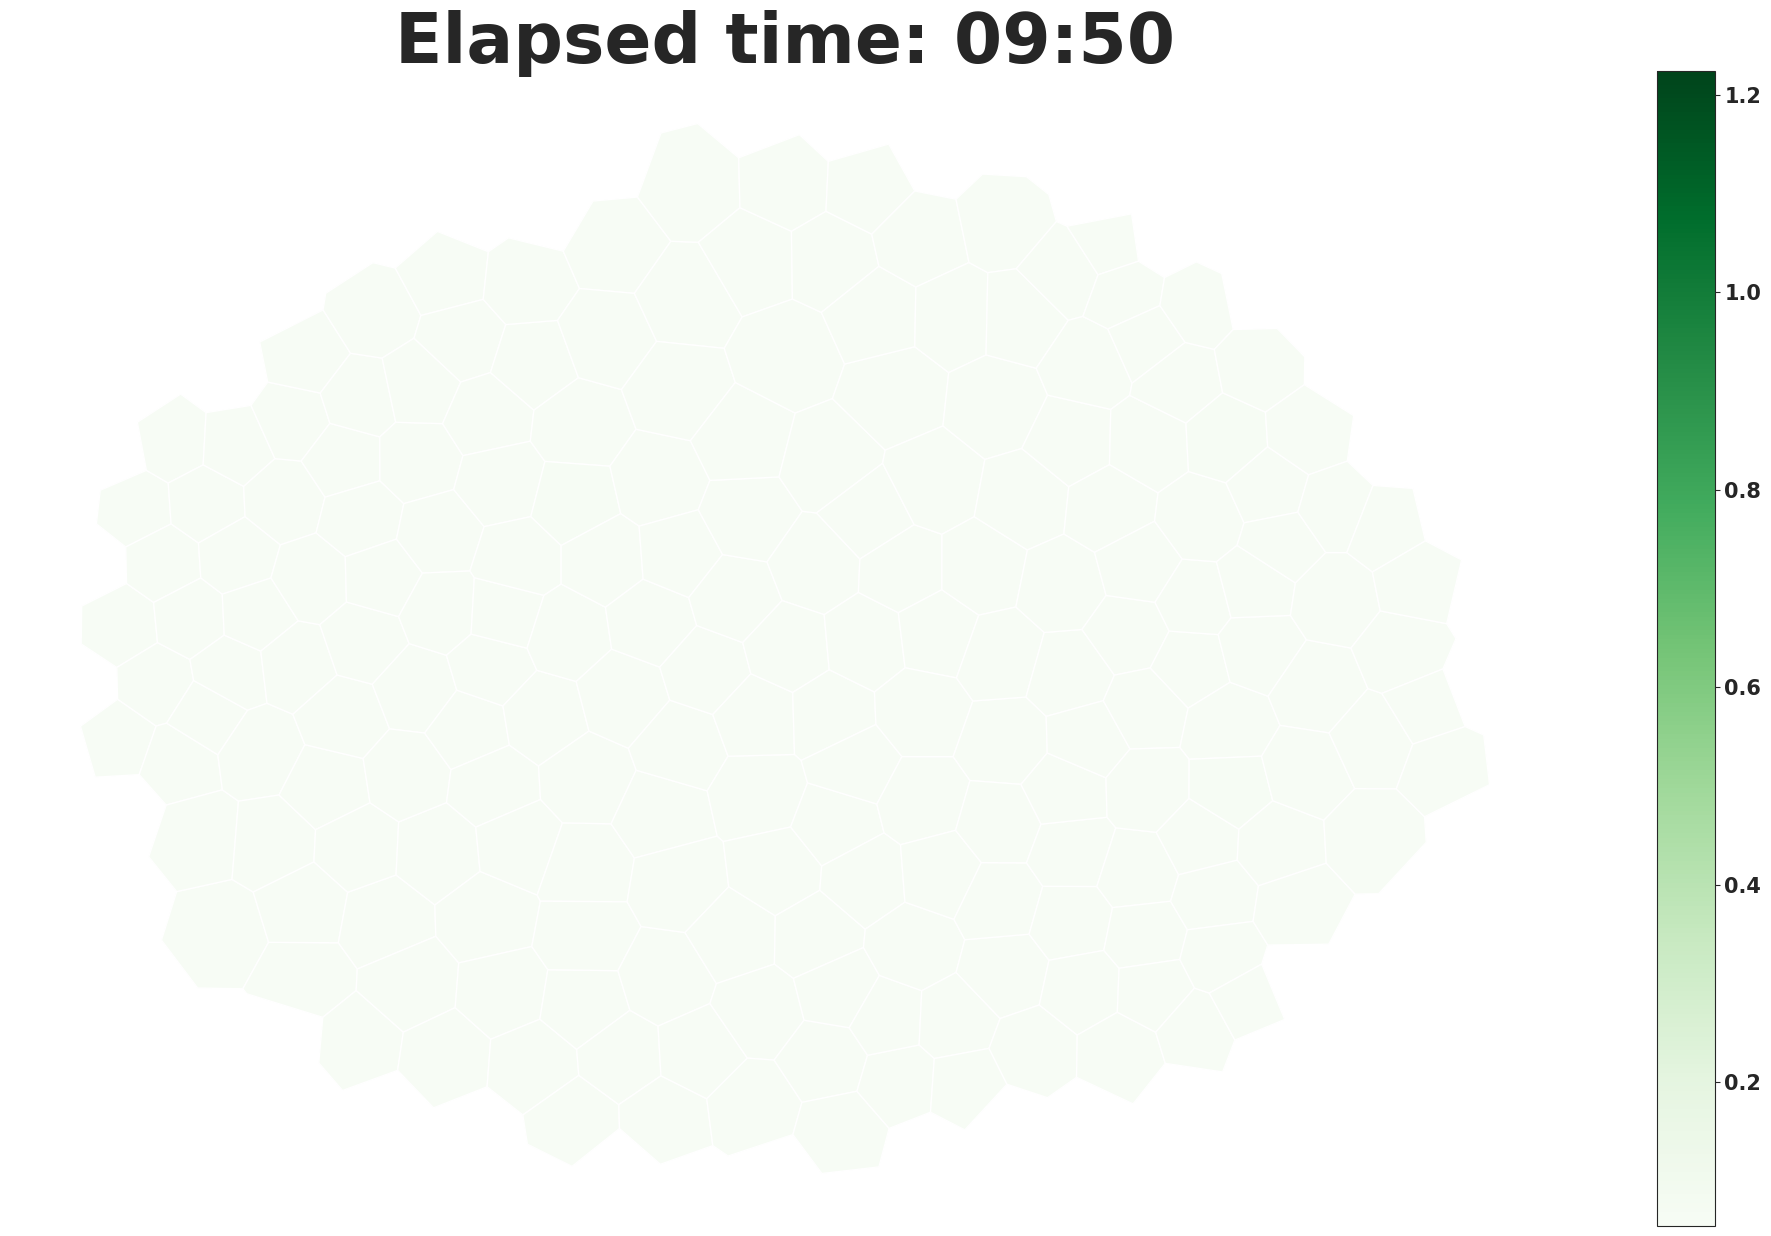

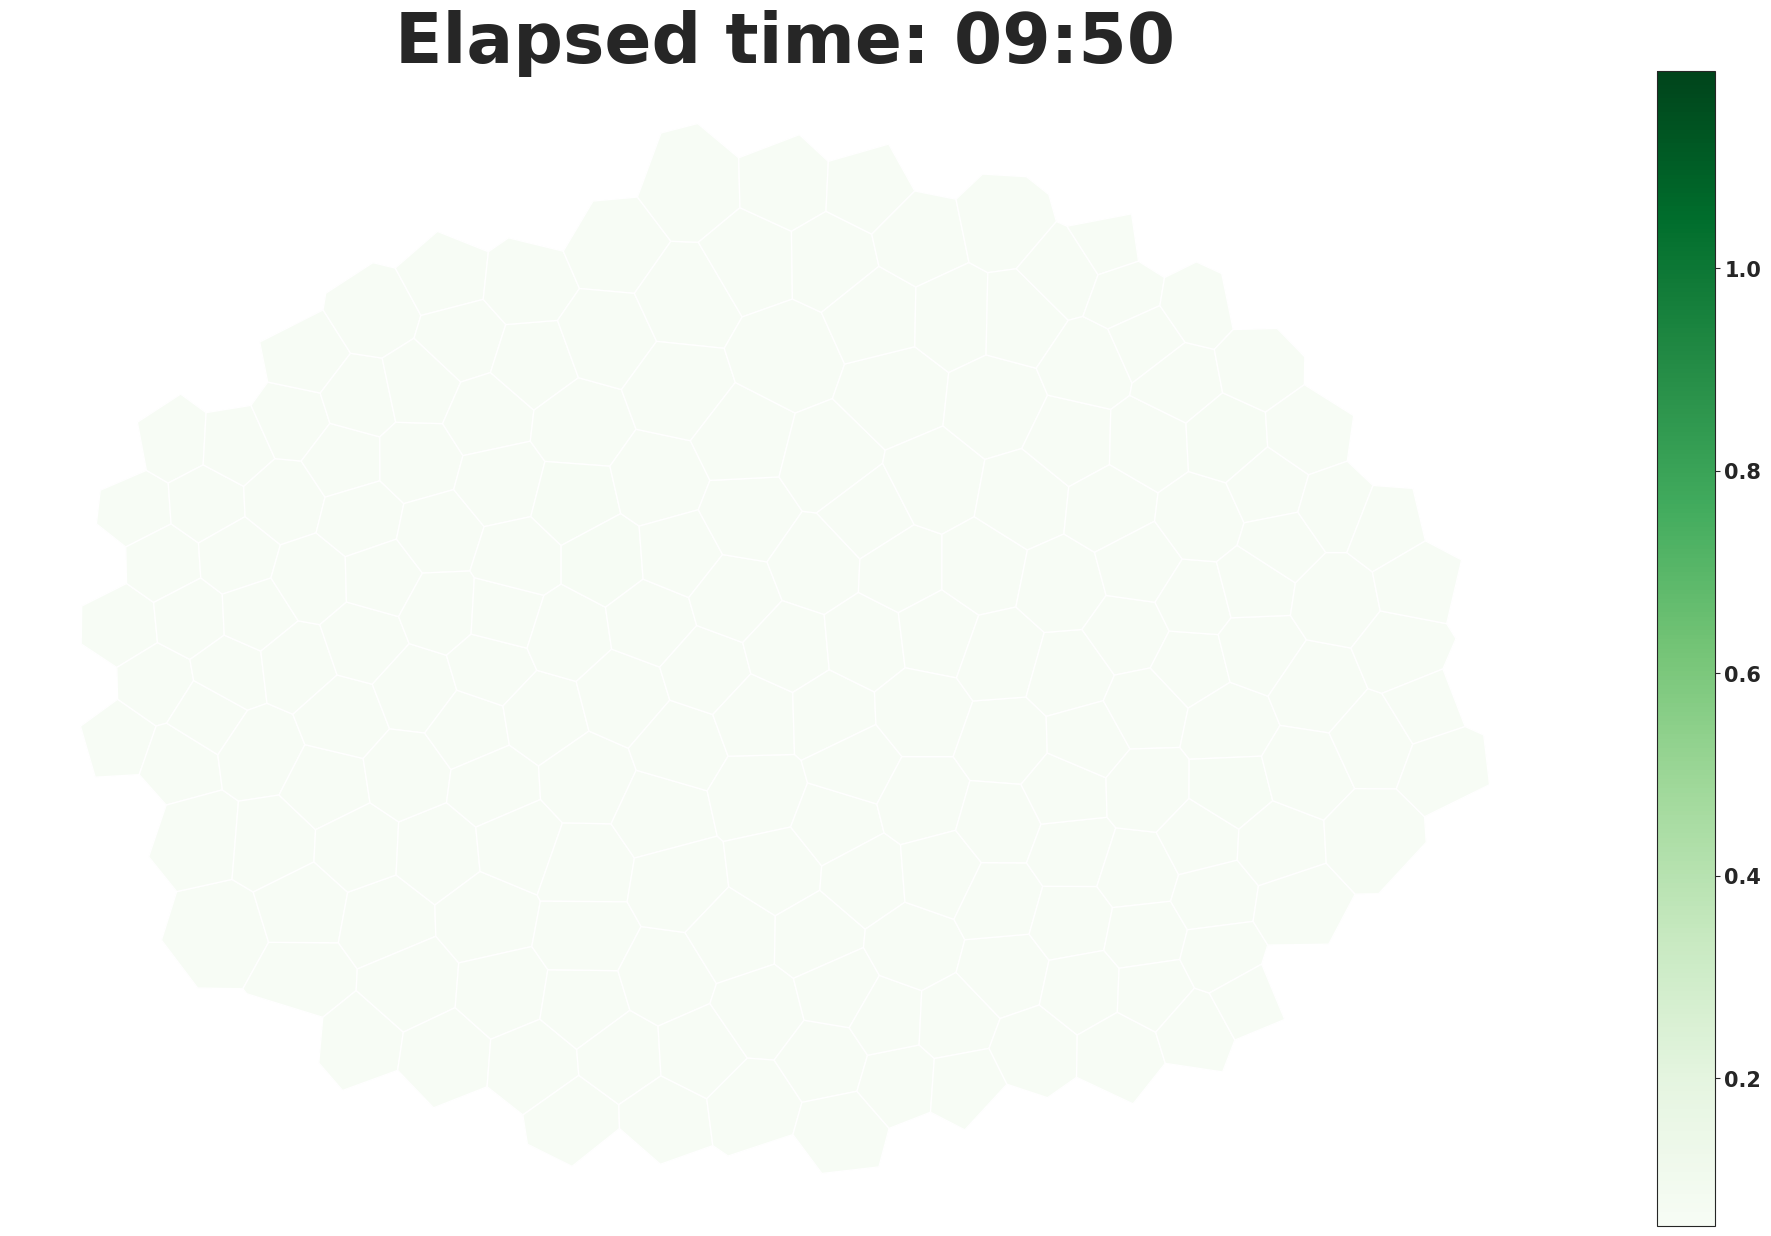

In [40]:
truth_anim = make_animation(truths_arr, new_vertices, interval=100)
# Save animation
truth_anim.save('true_calcium_dynamics_nextstep.mp4', writer='ffmpeg',
                    dpi=200)
preds_anim = make_animation(preds_arr, new_vertices, interval=100)
# Save animation
preds_anim.save('predicted_calcium_dynamics_nextstep.mp4', writer='ffmpeg',
                    dpi=200)

## Test with higher VPLC simulation

In [42]:
wave_params = {
    'lower': 0.4,
    'upper': 0.8,
}

wave_pouch = caml.PouchModelScipy_dense(laplacian_matrix, sim_time=3600, dt=1,
                                t_eval_boolean=True,
                                param_dict=wave_params,
                                random_seed=123456
                                )

t_sim = time.perf_counter()
sig_wave = wave_pouch.simulate()
print(f"Wave simulation took {time.perf_counter() - t_sim:.4f} seconds")

Wave simulation took 133.4834 seconds


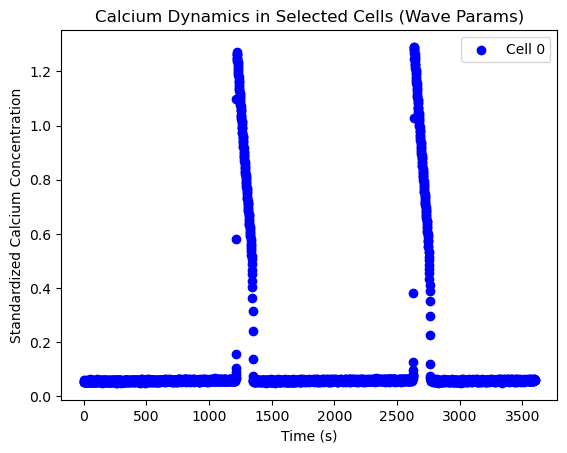

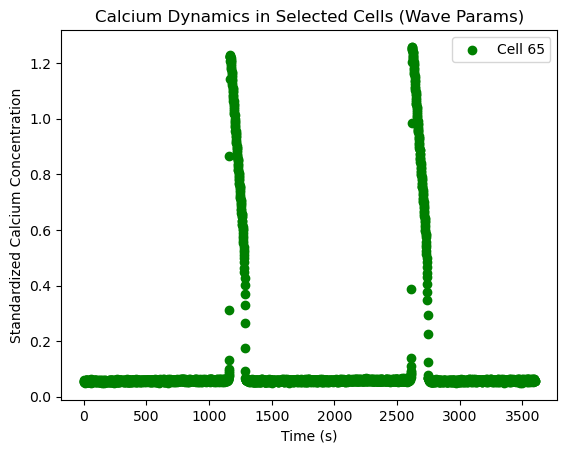

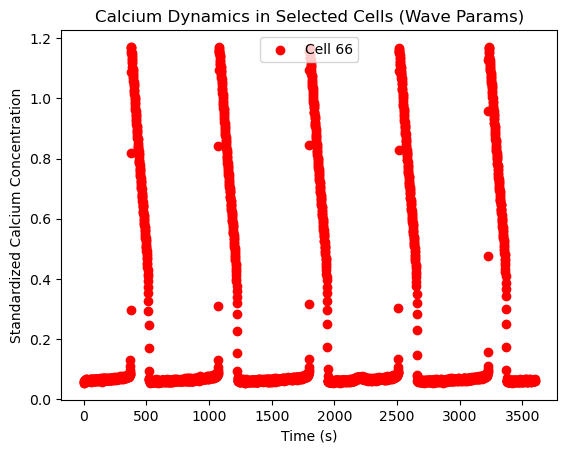

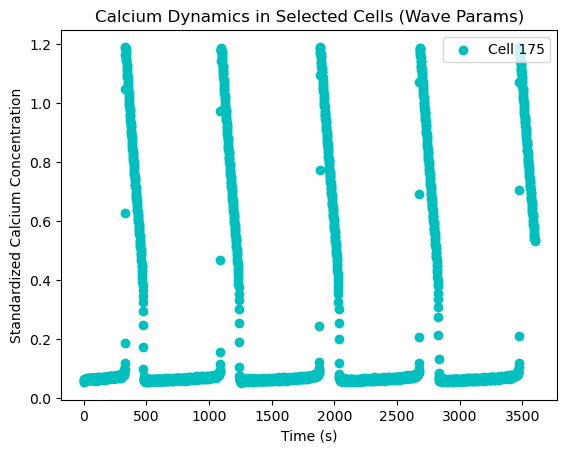

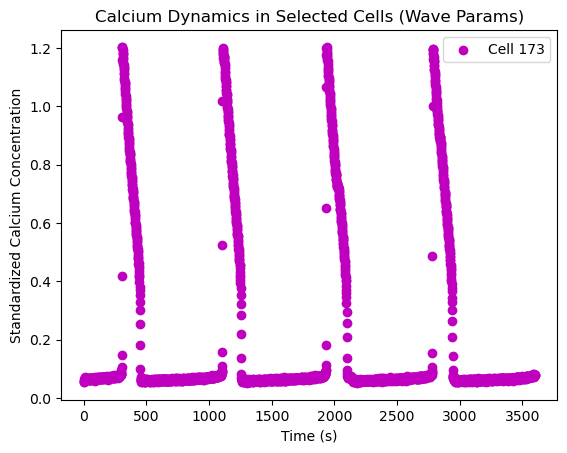

In [45]:
# Extract Calcium concentration
ca_wave = sig_wave.y[:num_cells, :]
# Add noise
np.random.seed(123456)
ca_wave_noisy = ca_wave + np.random.normal(0, 0.01 * np.std(ca_wave), ca_wave.shape)

# Plot a few example cells to visualize the calcium dynamics
cell_indices = [0, 65, 66, 175 ,173 ]  # Example cell indices
colors = ['b', 'g', 'r', 'c', 'm']
for i in cell_indices:
    plt.scatter(time_points2[1:], ca_wave_noisy[i, 1:], label=f'Cell {i}', color=colors[cell_indices.index(i) % len(colors)])
    plt.xlabel('Time (s)')
    plt.ylabel('Standardized Calcium Concentration')
    plt.title('Calcium Dynamics in Selected Cells (Wave Params)')
    plt.legend()
    plt.show()

/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_46520/2185976013.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=15,fontweight="bold")


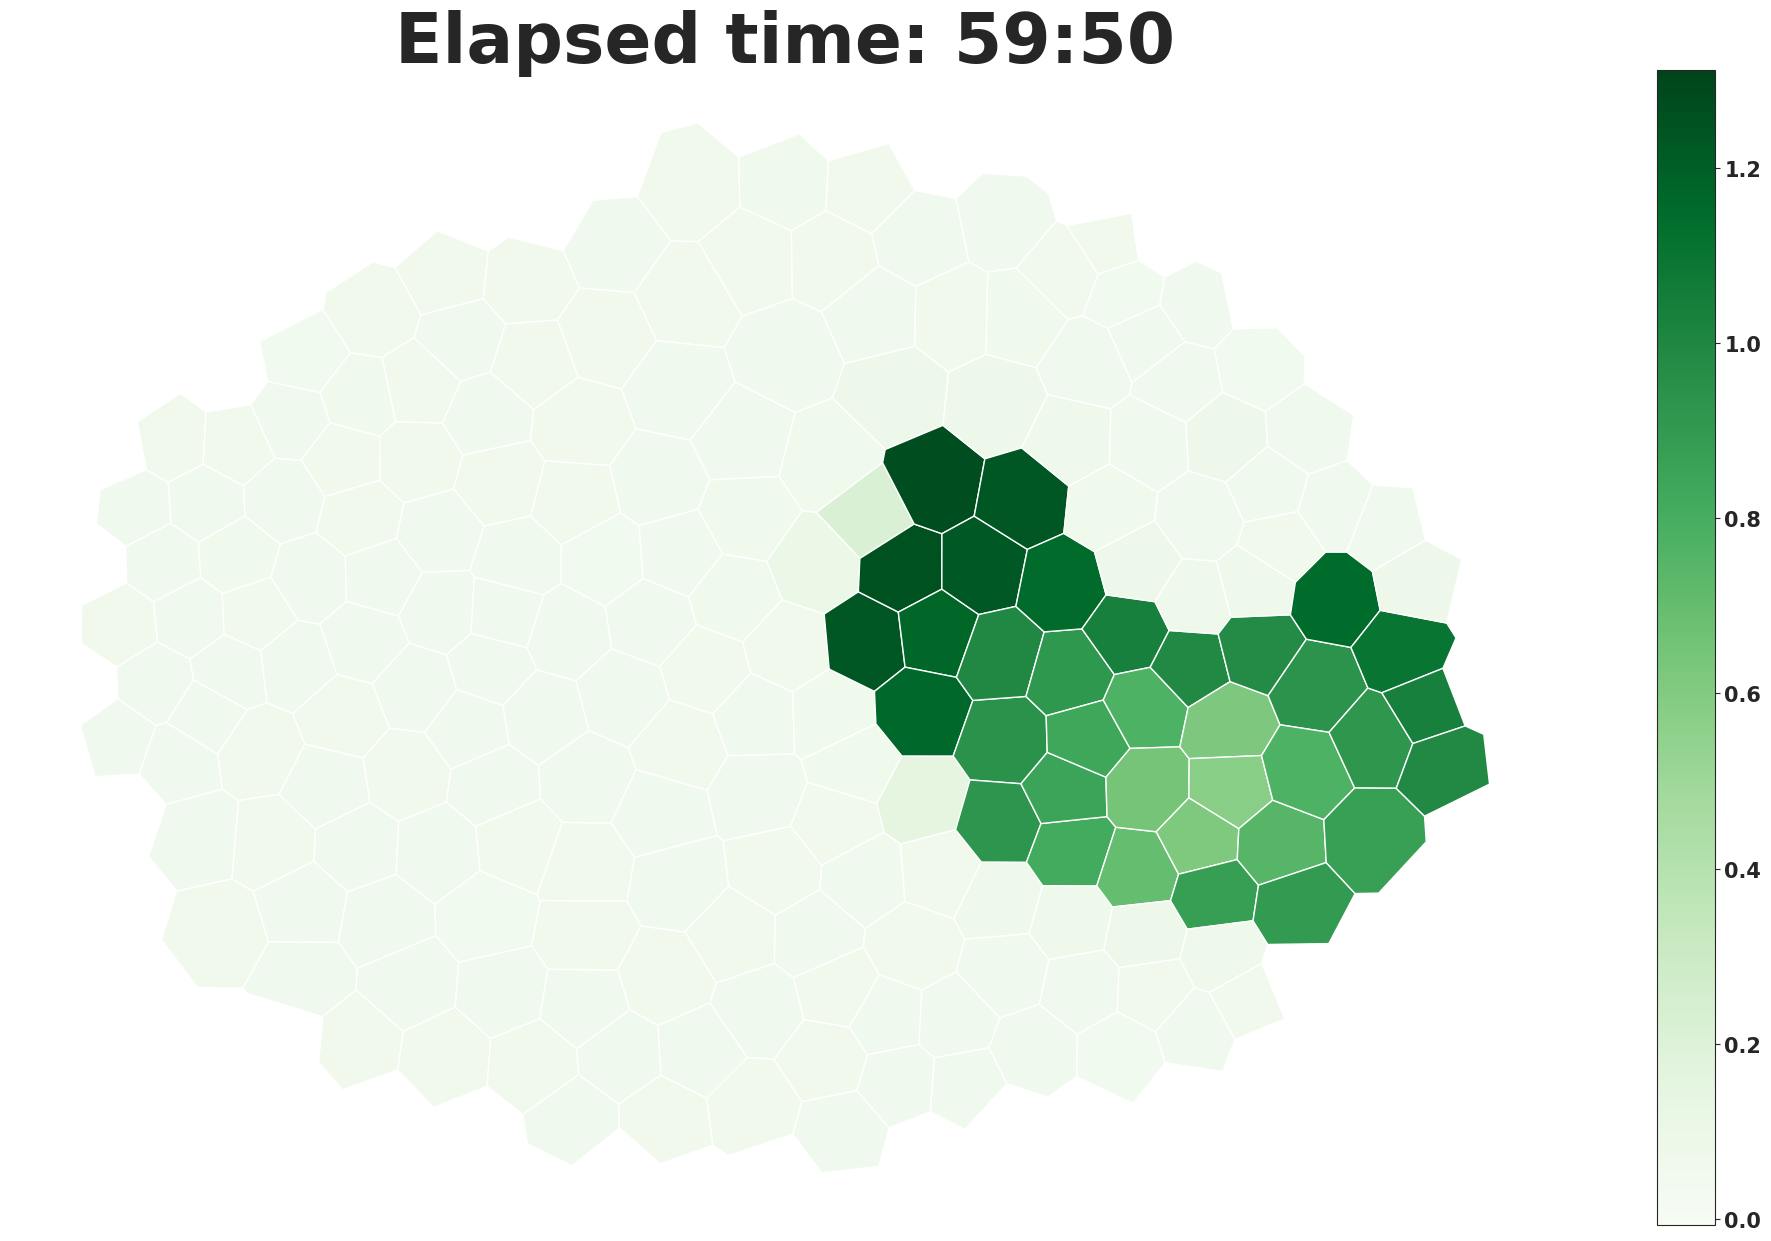

In [48]:
# Make animation of wave dynamics
wave_anim = make_animation(ca_wave_noisy, new_vertices, interval=50)
# Save animation
wave_anim.save('wave_calcium_dynamics.mp4', writer='ffmpeg',
                    dpi=200)

In [ ]:
# Make ca_wave_noisy into a PouchTemporalDataset
wave_dataset = PouchTemporalDataset(ca_wave_noisy, edge_index)

# # Save wave_dataset for future use
# torch.save(wave_dataset, 'wave_pouch_temporal_dataset11202025.pt')

# Evaluate next-step model on wave data
wave_preds_list, wave_truths_list = evaluate_nextstep(model_nextstep, wave_dataset)
wave_truths_arr = torch.stack([t.squeeze(1) for t in wave_truths_list], dim=1).numpy()  # (N, T_wave)
wave_preds_arr  = torch.stack([p.squeeze(1) for p in wave_preds_list
],  dim=1).numpy()  # (N, T_wave)

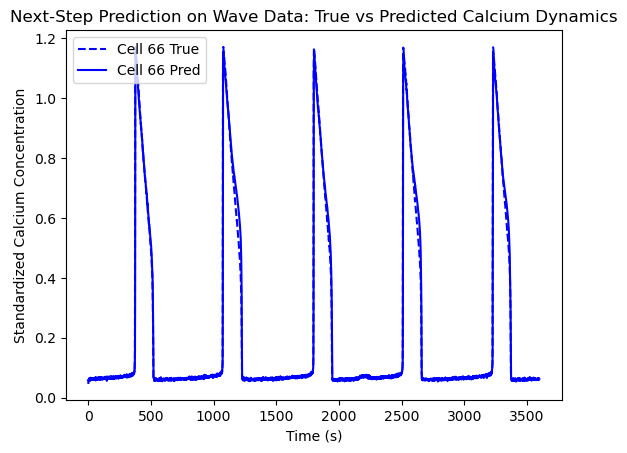

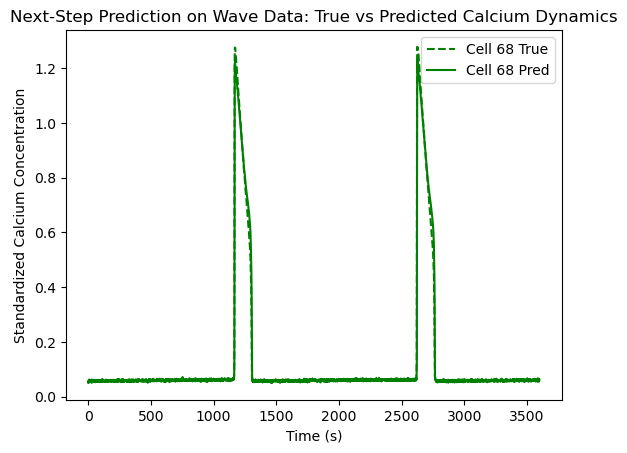

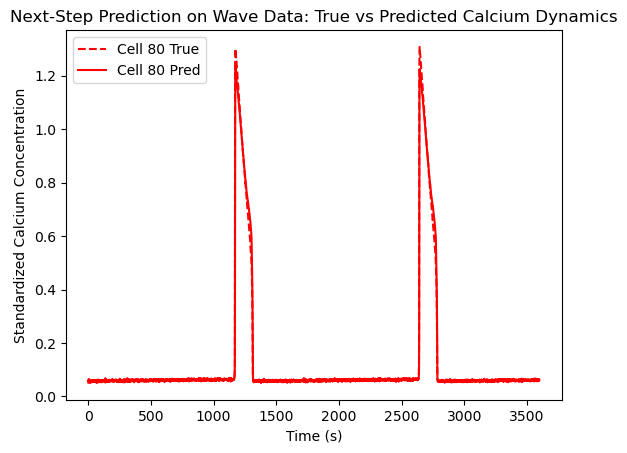

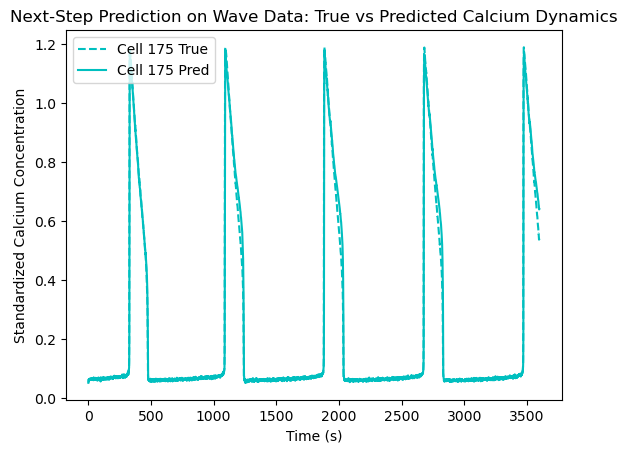

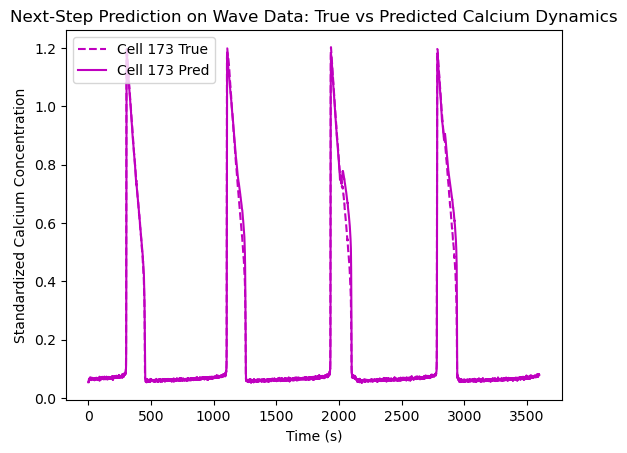

In [82]:
# Plot results for a few example cells
timepoints_wave = time_points2[1:wave_truths_arr.shape[1]+1]
cell_indices = [66, 68,  80, 175, 173,]  #Example cell indices
colors = ['b', 'g', 'r', 'c', 'm']
for i in cell_indices:
    plt.plot(timepoints_wave, wave_truths_arr[i, :], label=f'Cell {i} True', color=colors[cell_indices.index(i) % len(colors)], linestyle='--')
    plt.plot(timepoints_wave, wave_preds_arr[i, :], label=f'Cell {i} Pred', color=colors[cell_indices.index(i) % len(colors)], linestyle='-')
    plt.xlabel('Time (s)')
    plt.ylabel('Standardized Calcium Concentration')
    plt.title('Next-Step Prediction on Wave Data: True vs Predicted Calcium Dynamics')
    plt.legend()
    plt.show()

/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_46520/2185976013.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=15,fontweight="bold")


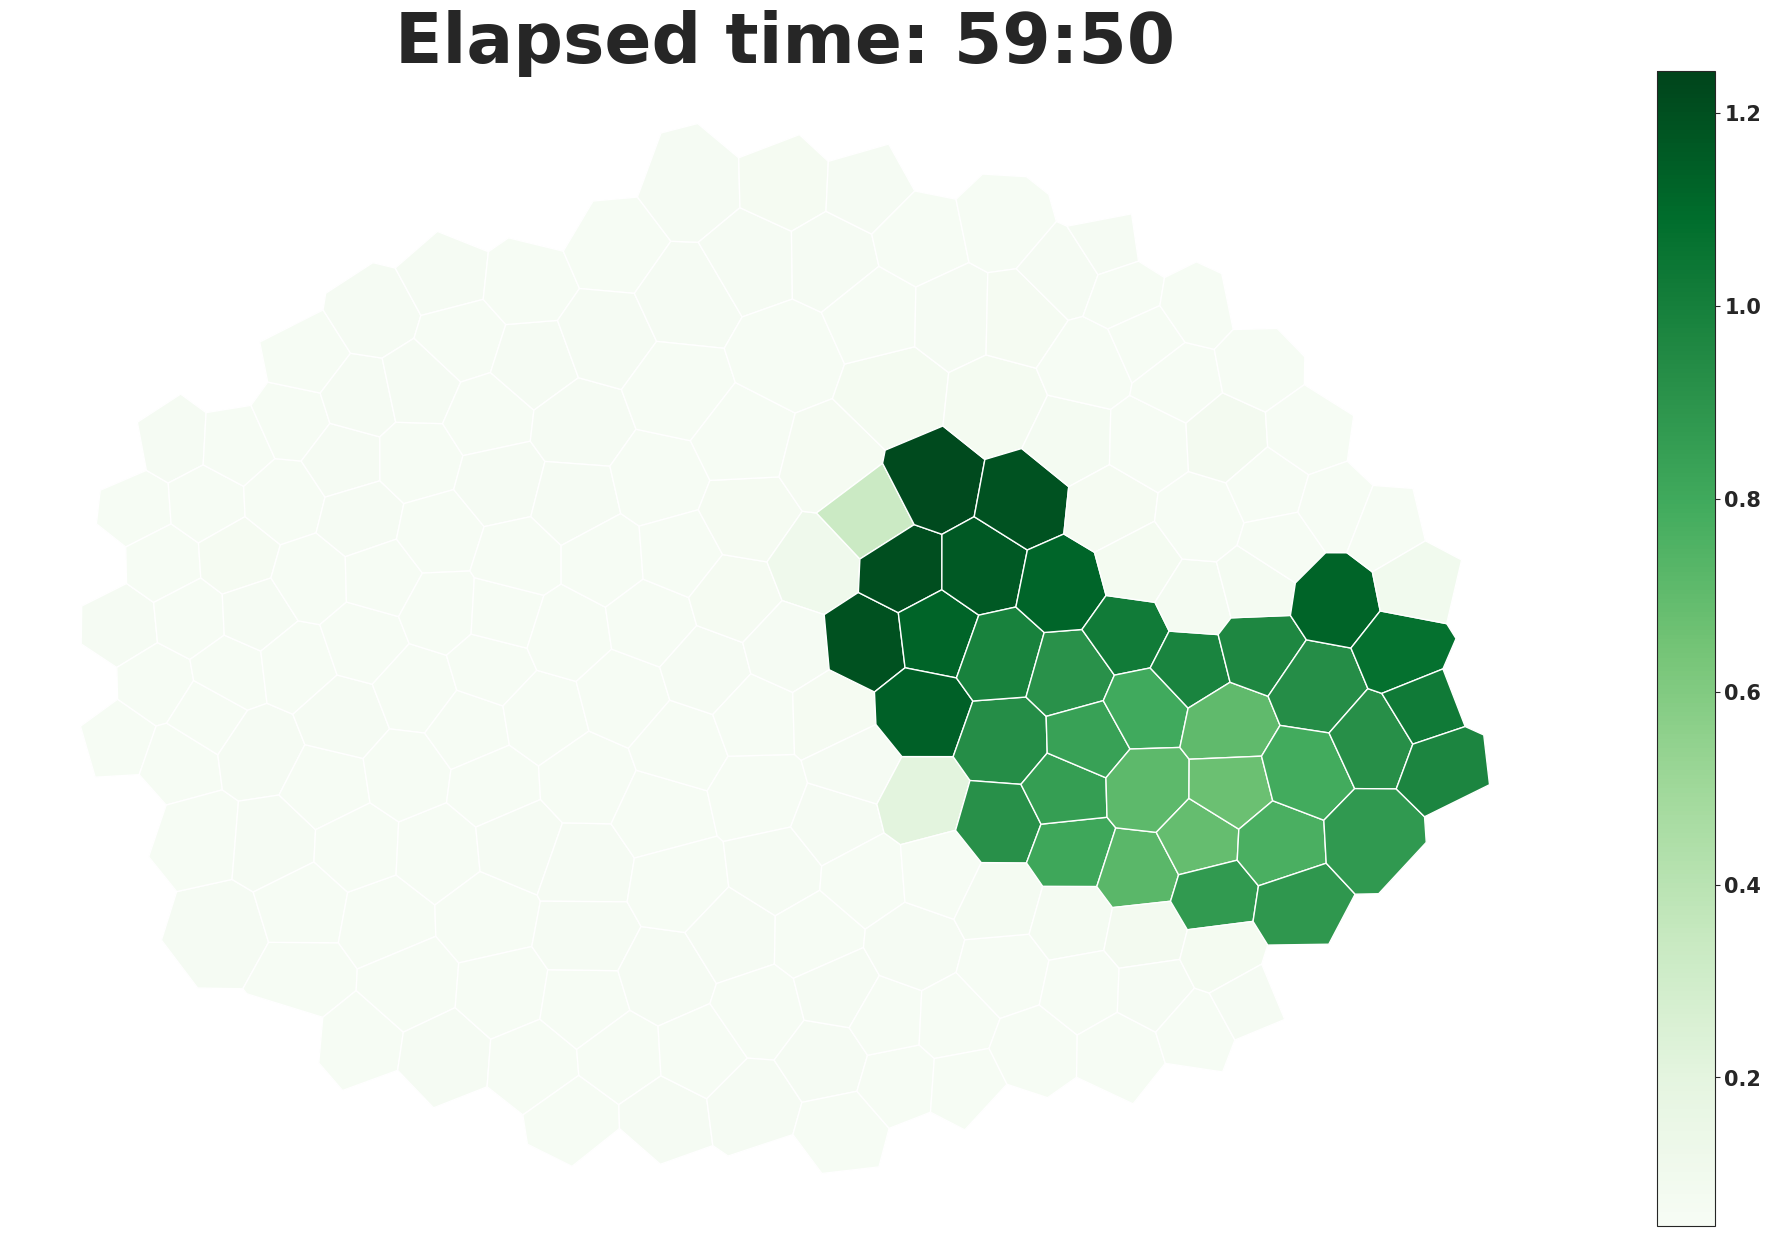

In [53]:
# Make animation of wave dynamics for next-step predictions
wave_preds_anim = make_animation(wave_preds_arr, new_vertices, interval=50)
# Save animation
wave_preds_anim.save('wave_predicted_calcium_dynamics_nextstep.mp4', writer='ffmpeg',
                    dpi=200)

/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_46520/487646521.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=15,fontweight="bold")


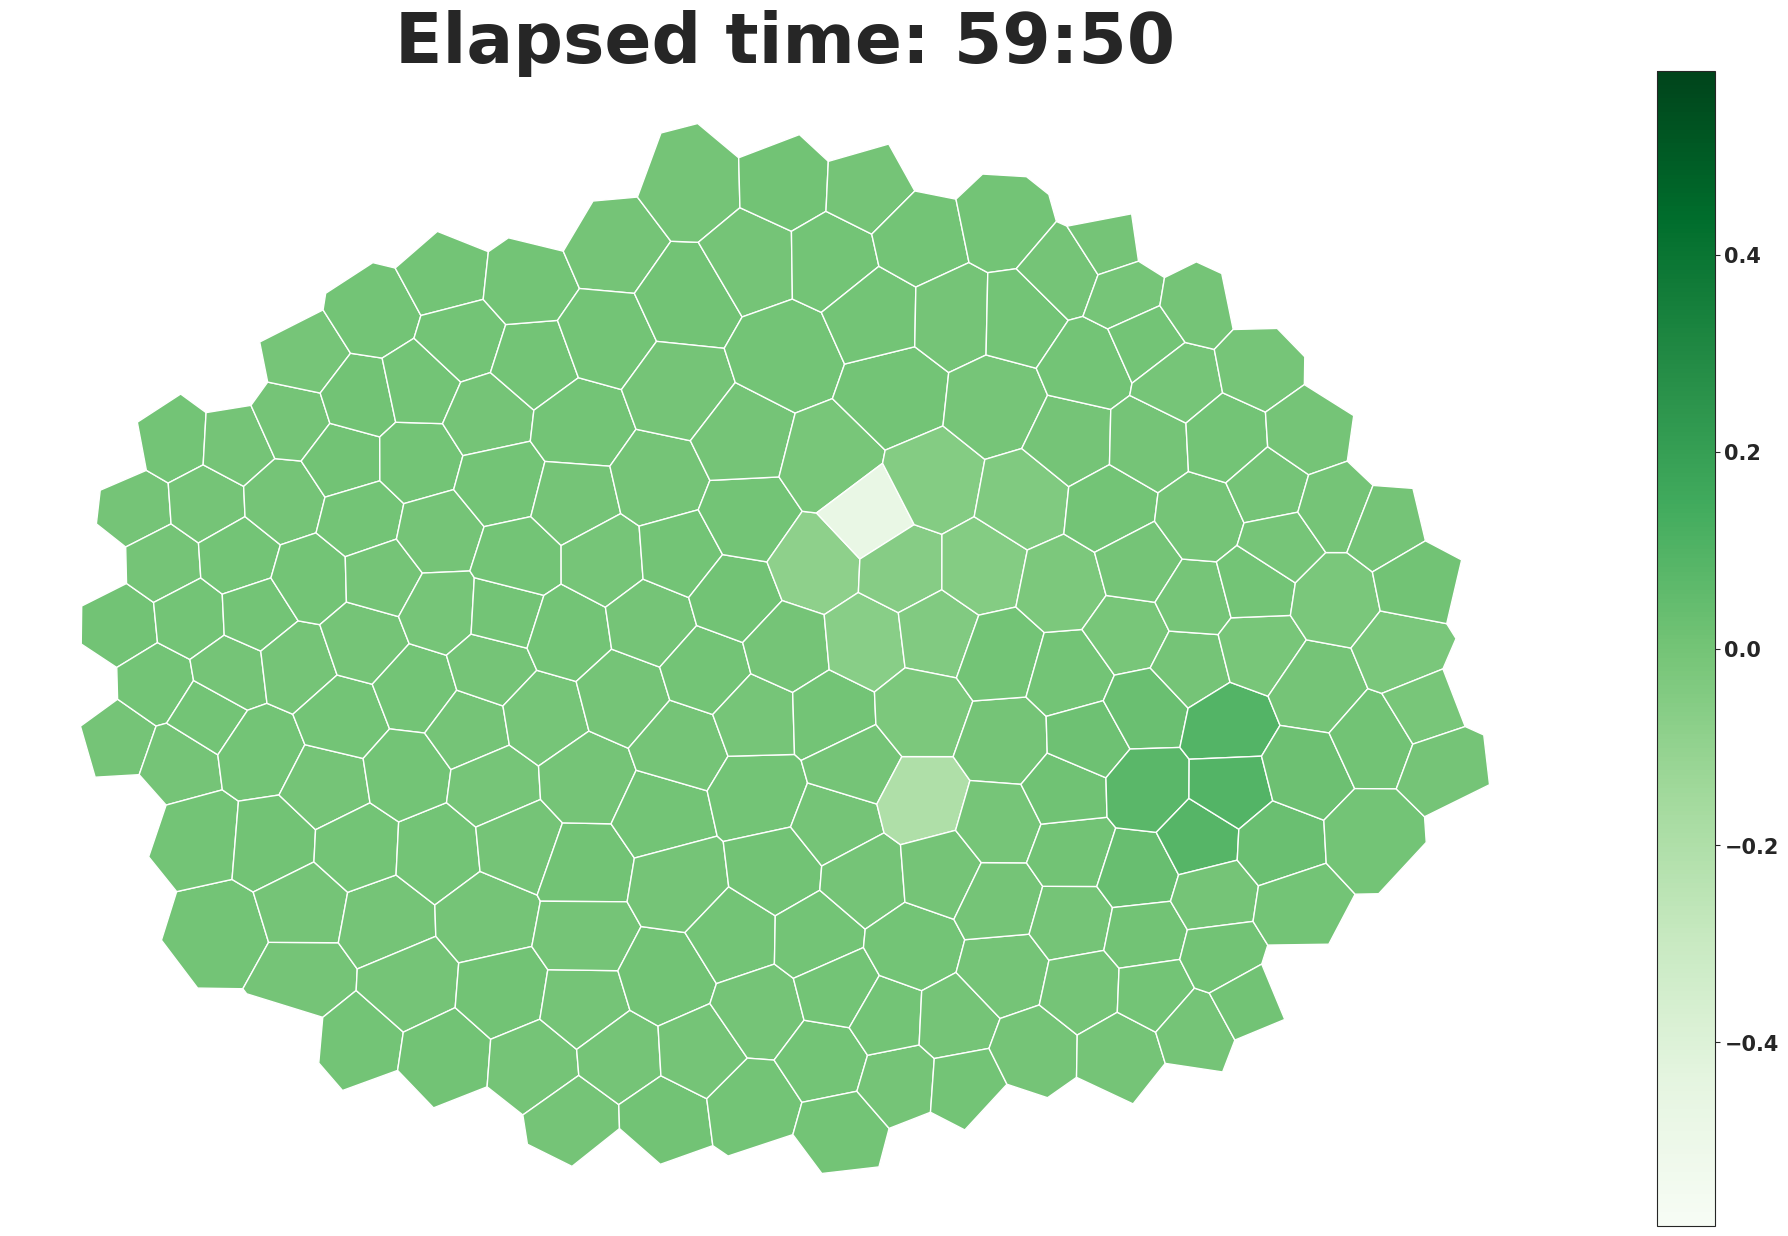

In [58]:
# Take difference of preds and truths
diff_arr = wave_preds_arr - wave_truths_arr

# Make animation of difference
diff_anim = make_animation(diff_arr, new_vertices, interval=50, normalize_flag=False)
# Save animation
diff_anim.save('wave_difference_calcium_dynamics_nextstep.mp4', writer='ffmpeg',
                    dpi=200)

In [129]:
from sklearn.ensemble import RandomForestClassifier
# Use Random Forest classifier to predict the initiator cells

# make model with sklearn
rf_model = RandomForestClassifier(n_estimators=100, random_state=123456, oob_score=True)

# Prepare training data
X_train = Ca_conc2_noisy[:, 1:] # Shape: (num_cells, time_steps)
y_train = np.zeros(X_train.shape[0])  # Initialize labels
print(X_train.shape)
y_train[stim_cells2] = 1  # Mark initiator cells

print("True initiator cells:", stim_cells2)

rf_model.fit(X_train, y_train)

# Plot feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print top features
# for f in range(X_train.shape[1]):
#     print(f"Feature {indices[f]}: Importance {importances[indices[f]]:.4f}")
# plt.figure(figsize=(50, 6))
# plt.title("Feature Importances from Random Forest")
# plt.bar(range(X_train.shape[1]), importances[indices], align='center')
# plt.xticks(range(X_train.shape[1]), indices)
# # turn labels diagonal
# plt.xticks(rotation=45, fontsize=12)
# plt.xlabel("Feature Index (Cell Index)", fontsize=14)
# plt.ylabel("Importance Score", fontsize=14)
# plt.show()


(195, 3599)
True initiator cells: [175  66 173]


In [130]:

# Now evaluate on wave data
X_wave = wave_preds_arr  # Shape: (num_cells, time_steps)
y_wave_pred = rf_model.predict(X_wave)
# print("Predicted labels for wave data:", y_wave_pred)
print("Predicted initiator cells in wave data:", np.where(y_wave_pred == 1)[0])

# Print ROC AUC score
from sklearn.metrics import roc_auc_score
y_wave_true = np.zeros(X_wave.shape[0])
y_wave_true[stim_cells2] = 1  # True initiator cells
roc_auc = roc_auc_score(y_wave_true, y_wave_pred)
print(f"ROC AUC Score on Wave Data: {roc_auc:.4f}")



Predicted initiator cells in wave data: [  9  34  66  80 162 173 175]
ROC AUC Score on Wave Data: 0.9896


In [131]:
# Evaluate on very different dataset
# (e.g., different parameters or geometry)
complex_params = {
    'lower': 0.4,
    'upper': 0.8,
    'frac': 0.3,
    'K_PLC': 0.2,
}

complex_pouch = caml.PouchModelScipy_dense(laplacian_matrix, sim_time=3600, dt=1,
                                t_eval_boolean=True,
                                param_dict=complex_params,
                                random_seed=528491,
                                )

t_sim_c = time.perf_counter()
sig_complex = complex_pouch.simulate()
print(f"Complex simulation took {time.perf_counter() - t_sim_c:.4f} seconds")


KeyboardInterrupt: 

[  9 163  65  12  49 145 181  36  12  31 116  78  72 178  51  42  14 150
 193 155 130 106 106 144 139 165 100 171 121  33  98 194  90  68  96  97
  32 134 159 155 138  32  28  13  49  81  46  39  45  67  29 192  10 181
  56 153  22 130]
58


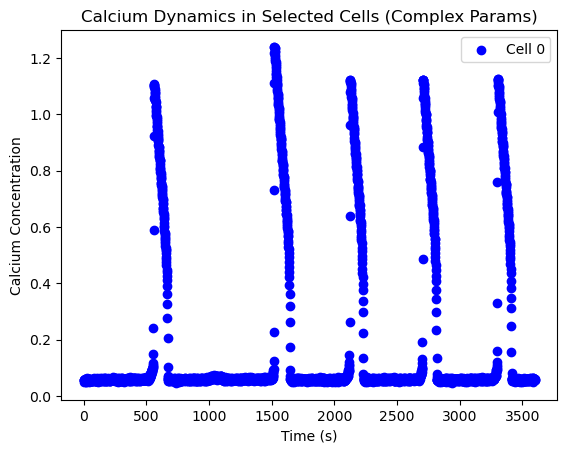

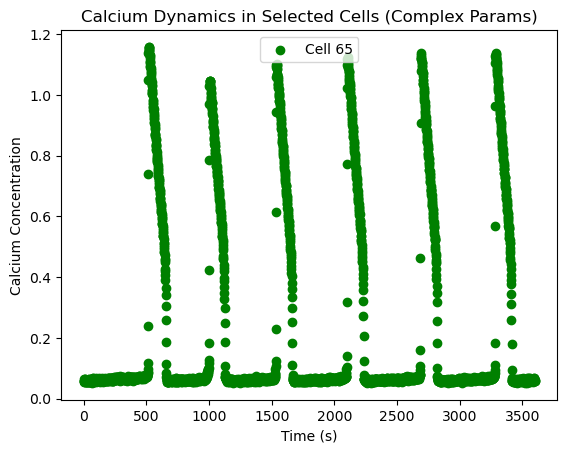

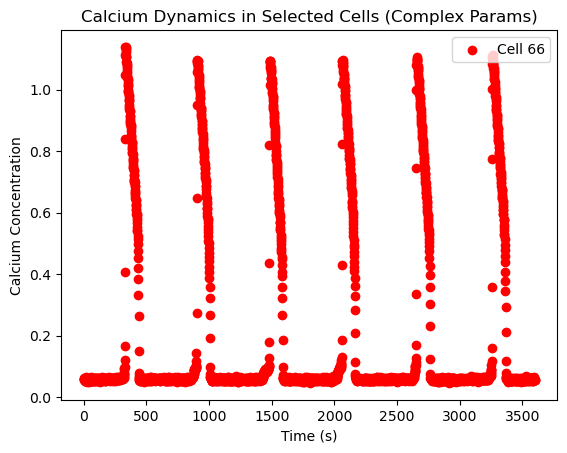

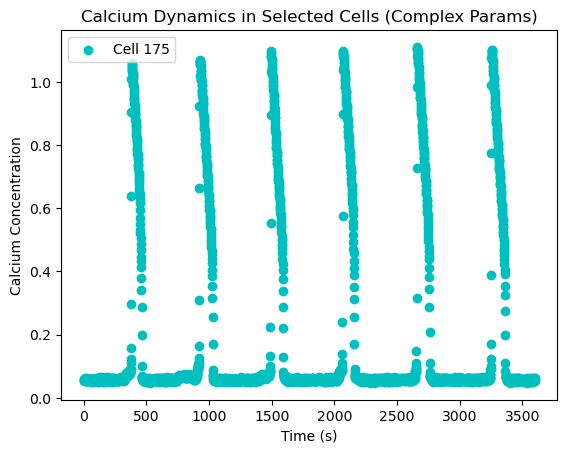

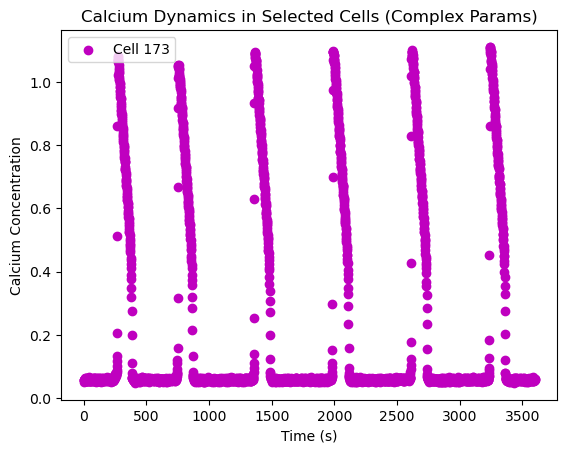

58


In [126]:
stim_cells_complex = complex_pouch.stimulated_cell_idxs
print(stim_cells_complex)
print(len(stim_cells_complex))

# Extract Calcium concentration
ca_complex = sig_complex.y[:num_cells, :]
# Add noise
np.random.seed(528491)
ca_complex_noisy = ca_complex + np.random.normal(0, 0.01 * np.std(ca_complex), ca_complex.shape)

# Plot a few example cells to visualize the calcium dynamics
cell_indices = [0, 65, 66, 175 ,173 ]  # Example cell indices
colors = ['b', 'g', 'r', 'c', 'm']
for i in cell_indices:
    plt.scatter(time_points2[1:], ca_complex_noisy[i, 1:], label=f'Cell {i}', color=colors[cell_indices.index(i) % len(colors)])
    plt.xlabel('Time (s)')
    plt.ylabel('Calcium Concentration')
    plt.title('Calcium Dynamics in Selected Cells (Complex Params)')
    plt.legend()
    plt.show()

print(len(stim_cells_complex))

In [124]:
# Now evaluate on complex data
X_complex = ca_complex_noisy[:, 1:]  # Shape: (num_cells, time_steps)
y_complex_pred = rf_model.predict(X_complex)
init_c_pred = np.where(y_complex_pred == 1)[0]
print("Predicted initiator cells in complex data:", init_c_pred)
print(len(init_c_pred))
# Print ROC AUC score
y_complex_true = np.zeros(X_complex.shape[0])
y_complex_true[stim_cells_complex] = 1  # True initiator cells
roc_auc_complex = roc_auc_score(y_complex_true, y_complex_pred)
print(f"ROC AUC Score on Complex Data: {roc_auc_complex:.4f}")

Predicted initiator cells in complex data: [  9  10  12  13  14  19  22  23  24  26  28  29  30  31  32  33  34  36
  39  40  42  43  44  45  46  49  51  55  56  65  67  68  69  71  72  77
  78  81  84  87  89  90  95  96  97  98  99 100 106 116 119 121 122 124
 128 130 132 134 135 138 139 144 145 146 150 153 155 157 159 162 163 165
 170 171 172 178 181 191 192 193 194]
81
ROC AUC Score on Complex Data: 0.8958


/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_46520/487646521.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=15,fontweight="bold")


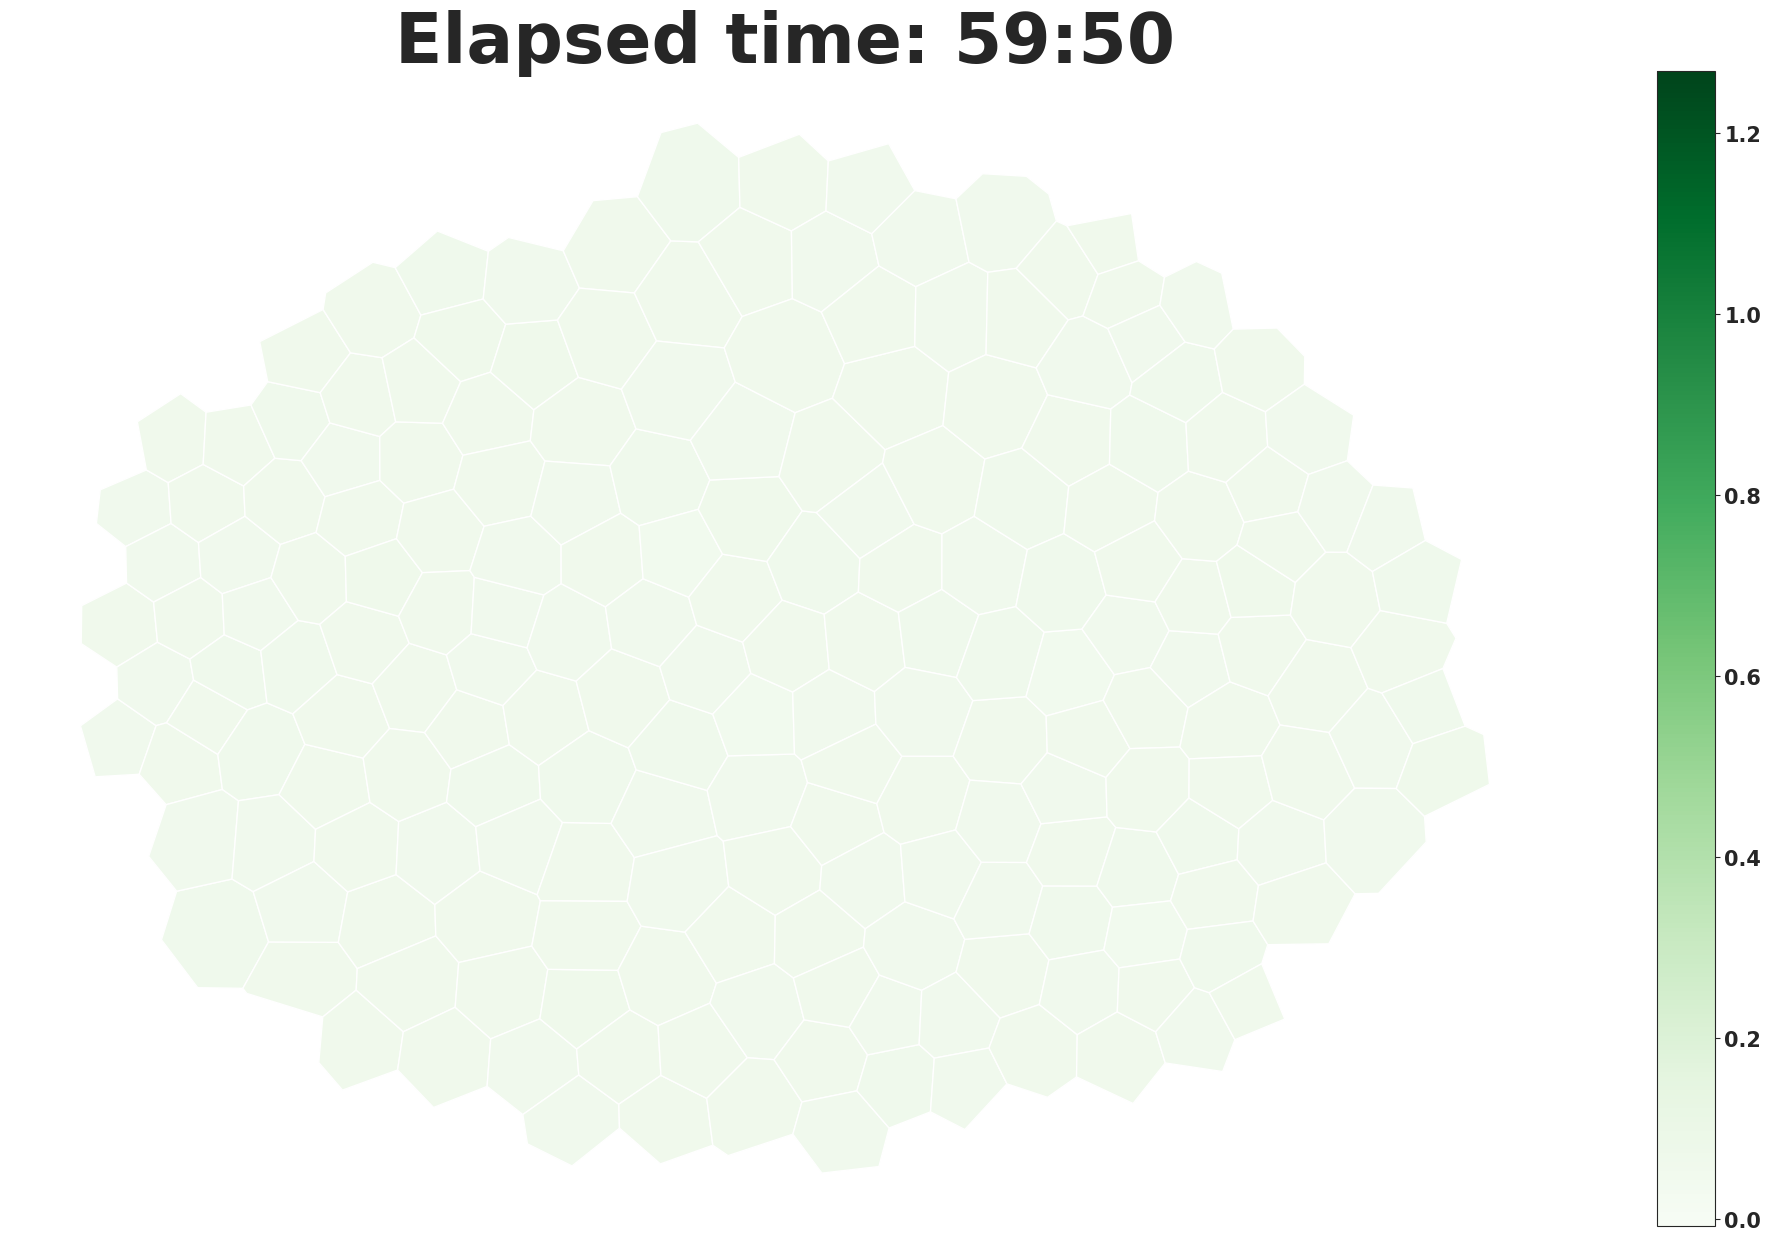

In [122]:
# Make animation for complex data wave dynamics
complex_anim = make_animation(ca_complex_noisy, new_vertices, interval=50)
# Save animation
complex_anim.save('complex_calcium_dynamics.mp4', writer='ffmpeg',
                    dpi=200)